In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

### Data Preparation

In [2]:
site_1 = pd.read_pickle("utilization_data_site1.pkl")
site_2 = pd.read_pickle("utilization_data_site2.pkl")

In [3]:
site_1_X = site_1.drop(columns = "utilization")
site_1_y = site_1['utilization']
site_2_X = site_2.drop(columns = 'utilization')
site_2_y = site_2['utilization']

In [4]:
# Split data into train, test, validation 60/20/20
site_1_X_train, site_1_X_test, site_1_y_train, site_1_y_test = train_test_split(site_1_X, site_1_y, test_size= 0.4, random_state=42)
site_2_X_train, site_2_X_test, site_2_y_train, site_2_y_test = train_test_split(site_2_X, site_2_y, test_size= 0.4, random_state=42)

site_1_X_test, site_1_X_val, site_1_y_test, site_1_y_val = train_test_split(site_1_X_test, site_1_y_test, test_size=0.5, random_state=42)
site_2_X_test, site_2_X_val, site_2_y_test, site_2_y_val = train_test_split(site_2_X_test, site_2_y_test, test_size=0.5, random_state=42)

In [5]:
# Scale data using MinMaxScaler from sklearn
site_1_scaler = MinMaxScaler()
site_2_scaler = MinMaxScaler()

site_1_scaler.fit(site_1_X_train)
site_2_scaler.fit(site_2_X_train)

site_1_X_train = site_1_scaler.fit_transform(site_1_X_train)
site_1_X_test  = site_1_scaler.transform(site_1_X_test)
site_1_X_val  = site_1_scaler.transform(site_1_X_val)


site_2_X_train = site_2_scaler.fit_transform(site_2_X_train)
site_2_X_test  = site_2_scaler.transform(site_2_X_test)
site_2_X_val  = site_2_scaler.transform(site_2_X_val)

In [6]:
print(site_1_X_train.shape)
print(site_1_X_test.shape)
print(site_1_X_val.shape)

(7782, 6)
(2594, 6)
(2595, 6)


### Polynomial Regression

In [7]:
site_1['hour'] = (site_1['hour'] - 8) % 24
site_1['hour'] = site_1['hour'].astype(int)
site_2['hour'] = (site_2['hour'] - 8) % 24
site_2['hour'] = site_2['hour'].astype(int)

In [8]:
xp = site_1["hour"]
yp = site_1["utilization"]

Text(0, 0.5, 'Utilization')

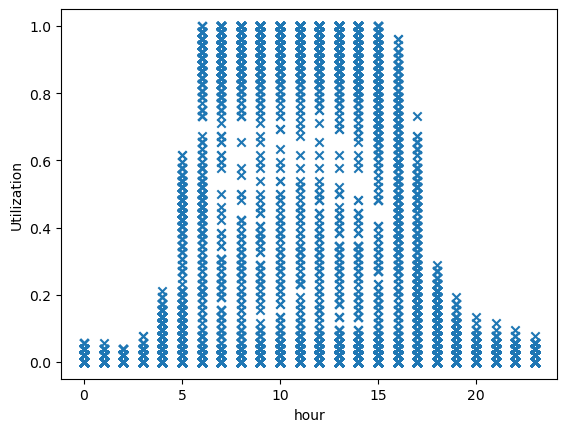

In [9]:
plt.scatter(xp, yp, marker='x')
plt.xlabel("hour")
plt.ylabel("Utilization")

First let us establish a baseline performance for a polynomial model. We consider polynomial degrees in the range of 1 to 14 and display the key metric performances per degree.

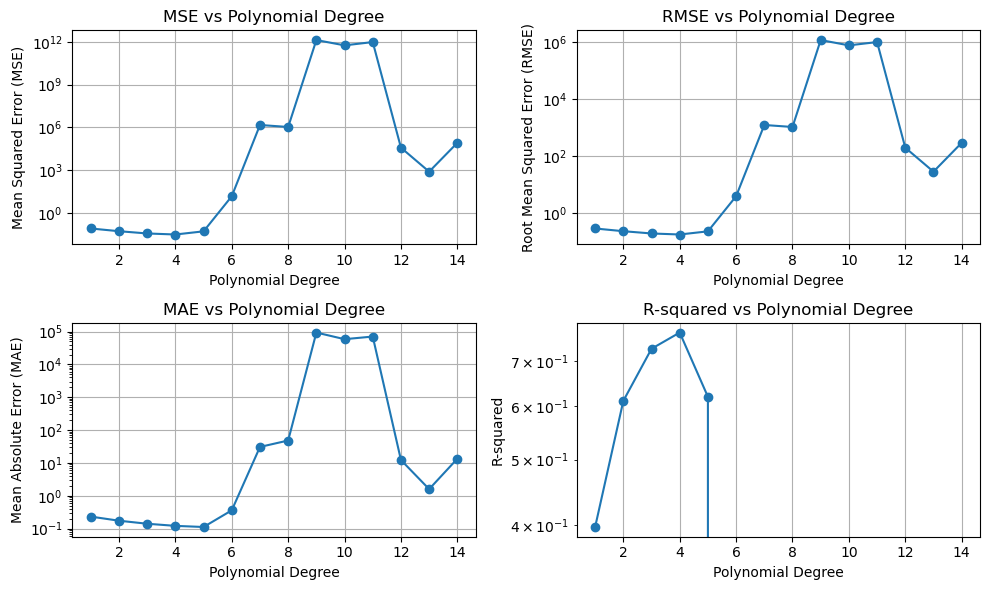

In [10]:
# Polynomial Regression without regularization

degrees = np.arange(1, 15)
mse_values = []
rmse_values = []
mae_values = []
r2_values = []

for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)
    site_1_X_train_poly = poly_features.fit_transform(site_1_X_train)
    site_1_X_val_poly = poly_features.transform(site_1_X_val)

    model = LinearRegression()
    model.fit(site_1_X_train_poly, site_1_y_train)

    y_pred = model.predict(site_1_X_val_poly)

    mse = mean_squared_error(site_1_y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(site_1_y_val, y_pred)
    r2 = r2_score(site_1_y_val, y_pred)

    # Append values to lists
    mse_values.append(mse)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)

# Plot the results
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(degrees, mse_values, marker='o')
plt.yscale('log')
plt.title('MSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(degrees, rmse_values, marker='o')
plt.yscale('log')
plt.title('RMSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(degrees, mae_values, marker='o')
plt.yscale('log')
plt.title('MAE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(degrees, r2_values, marker='o')
plt.yscale('log')
plt.title('R-squared vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.grid(True)

plt.tight_layout()
plt.show()

The metrics are not satisfactory. We shall utilize regularization to achieve better results.

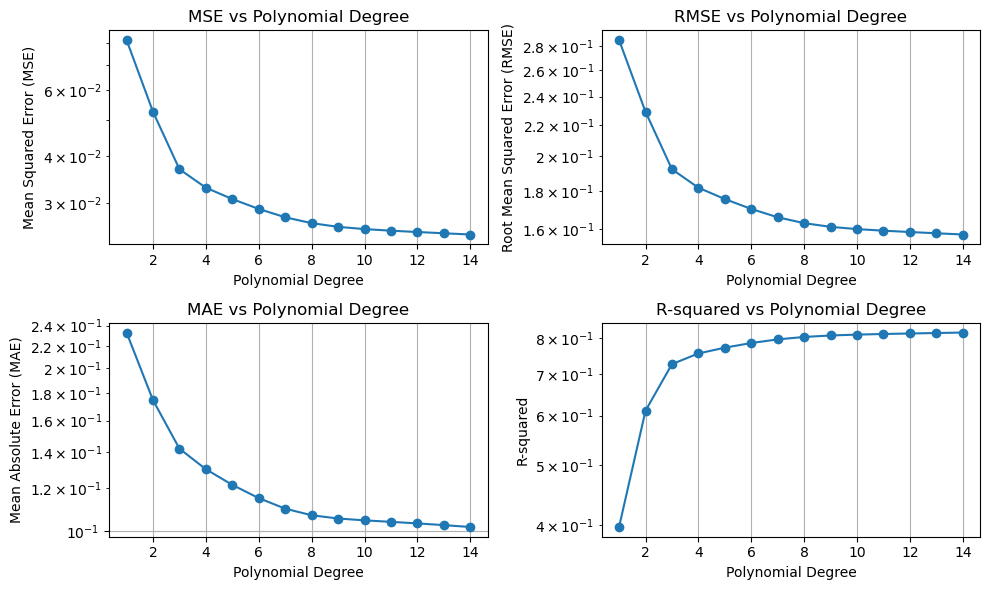

MSE für degree=6: 0.08130702996064919


In [11]:
#Polynomial Regression with L2 regularization

degrees = np.arange(1, 15)
alpha_values = np.logspace(-3, 3, 7)
mse_values = []
rmse_values = []
mae_values = []
r2_values = []

    
for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)
    site_1_X_train_poly = poly_features.fit_transform(site_1_X_train)
    site_1_X_val_poly = poly_features.transform(site_1_X_val)
    
    model = Ridge(alpha = 0.25)
    model.fit(site_1_X_train_poly, site_1_y_train)
    
    y_pred = model.predict(site_1_X_val_poly)
    
    mse = mean_squared_error(site_1_y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(site_1_y_val, y_pred)
    r2 = r2_score(site_1_y_val, y_pred)
    
    # Append values to lists
    mse_values.append(mse)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)

# Plot the results
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(degrees, mse_values, marker='o')
plt.yscale('log')
plt.title('MSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(degrees, rmse_values, marker='o')
plt.yscale('log')
plt.title('RMSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(degrees, mae_values, marker='o')
plt.yscale('log')
plt.title('MAE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(degrees, r2_values, marker='o')
plt.yscale('log')
plt.title('R-squared vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"MSE für degree=6: {mse_values[0]}")

The results are far better than without any regularization. The graphs show that with increasing polynomial degree the key metrics improve but stagnate at around the 6th degree.

As an additional hyperparameter, let us also consider the amount of regularizaion (alpha) we apply to our model.

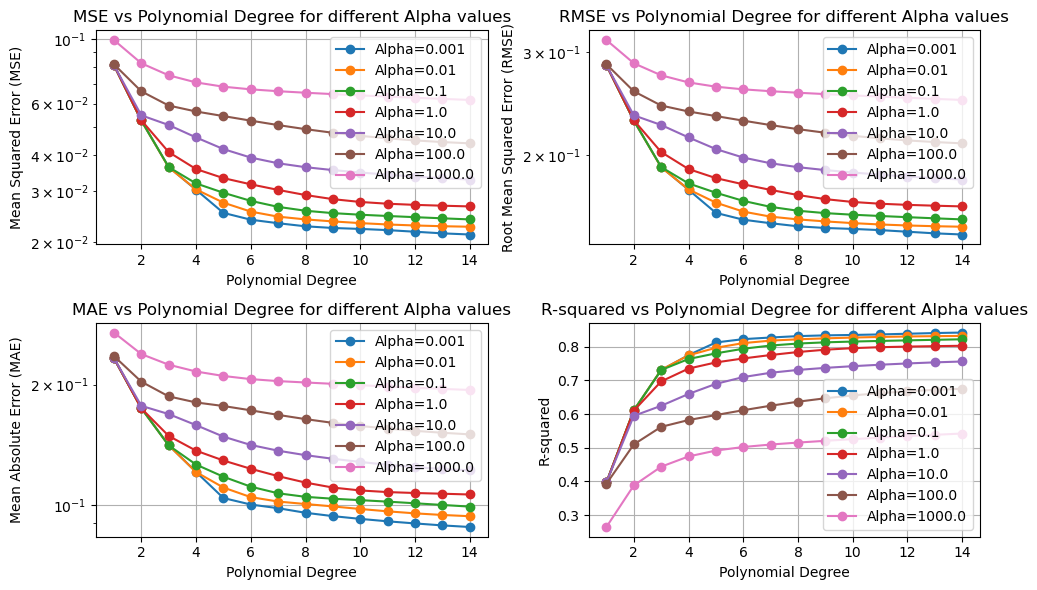

MSE für degree=6 und Alpha=0.001: 0.023904496173361163
MSE für degree=6 und Alpha=0.01: 0.02548759892871482
MSE für degree=6 und Alpha=0.1: 0.027746973651546804
MSE für degree=6 und Alpha=1.0: 0.03163545717466356
MSE für degree=6 und Alpha=10.0: 0.03910170416983935
MSE für degree=6 und Alpha=100.0: 0.05238579176639758
MSE für degree=6 und Alpha=1000.0: 0.0671269107203608


In [12]:
degrees = np.arange(1, 15)
alpha_values = np.logspace(-3, 3, 7)
mse_values = np.zeros((len(alpha_values), len(degrees)))
rmse_values = np.zeros((len(alpha_values), len(degrees)))
mae_values = np.zeros((len(alpha_values), len(degrees)))
r2_values = np.zeros((len(alpha_values), len(degrees)))

for i, alpha in enumerate(alpha_values):
    for j, degree in enumerate(degrees):
        poly_features = PolynomialFeatures(degree=degree)
        site_1_X_train_poly = poly_features.fit_transform(site_1_X_train)
        site_1_X_val_poly = poly_features.transform(site_1_X_val)

        model = Ridge(alpha=alpha)
        model.fit(site_1_X_train_poly, site_1_y_train)

        y_pred = model.predict(site_1_X_val_poly)

        mse = mean_squared_error(site_1_y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(site_1_y_val, y_pred)
        r2 = r2_score(site_1_y_val, y_pred)

        mse_values[i, j] = mse
        rmse_values[i, j] = rmse
        mae_values[i, j] = mae
        r2_values[i, j] = r2

# Plot the results
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale('log')
plt.title('MSE vs Polynomial Degree for different Alpha values')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, rmse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale('log')
plt.title('RMSE vs Polynomial Degree for different Alpha values')
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mae_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale('log')
plt.title('MAE vs Polynomial Degree for different Alpha values')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, r2_values[i], marker='o', label=f'Alpha={alpha}')
plt.title('R-squared vs Polynomial Degree for different Alpha values')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the MSE for degree=6 for each alpha value
for i, alpha in enumerate(alpha_values):
    print(f"MSE für degree=6 und Alpha={alpha}: {mse_values[i, 5]}")


In [13]:
print(f"MSE für degree=6: {mse_values[5]}")
print(f"RMSE für degree=6: {rmse_values[5]}")
print(f"MAE für degree=6: {mae_values[5]}")
print(f"R^2 für degree=6: {r2_values[5]}")

MSE für degree=6: [0.08186228 0.0660985  0.05904595 0.05632786 0.05431571 0.05238579
 0.05057992 0.04897033 0.04759175 0.0464491  0.04552627 0.04479403
 0.04421784 0.04376412]
RMSE für degree=6: [0.28611585 0.25709629 0.24299373 0.2373349  0.23305731 0.22887943
 0.22489981 0.22129241 0.21815534 0.21552053 0.21336885 0.21164601
 0.21028039 0.20919875]
MAE für degree=6: [0.23584867 0.20350132 0.18695137 0.18052715 0.17685026 0.17251114
 0.16802512 0.16398084 0.1604807  0.15763417 0.1552804  0.15327749
 0.15159738 0.15016734]
R^2 für degree=6: [0.39310909 0.50997481 0.56225931 0.58241007 0.59732724 0.6116348
 0.62502271 0.63695553 0.64717569 0.65564682 0.66248831 0.66791675
 0.6721884  0.67555211]


As we can see (at least in the first 14 instances) the benchmarks for the polynomial regression improve with higher polynomial degrees. However, we do not want to risk any overfitting, therefore, we will say that a polynomial degree of 6 is sufficient for our model.

Furthermore, lower alpha values for the ridge regression also improve the outcomes for the benchmarks. Choosing alpha as too low, however, increases the risk of overfitting to the training set and worse generalization. Thus, we will choose an alpha of 0,1.

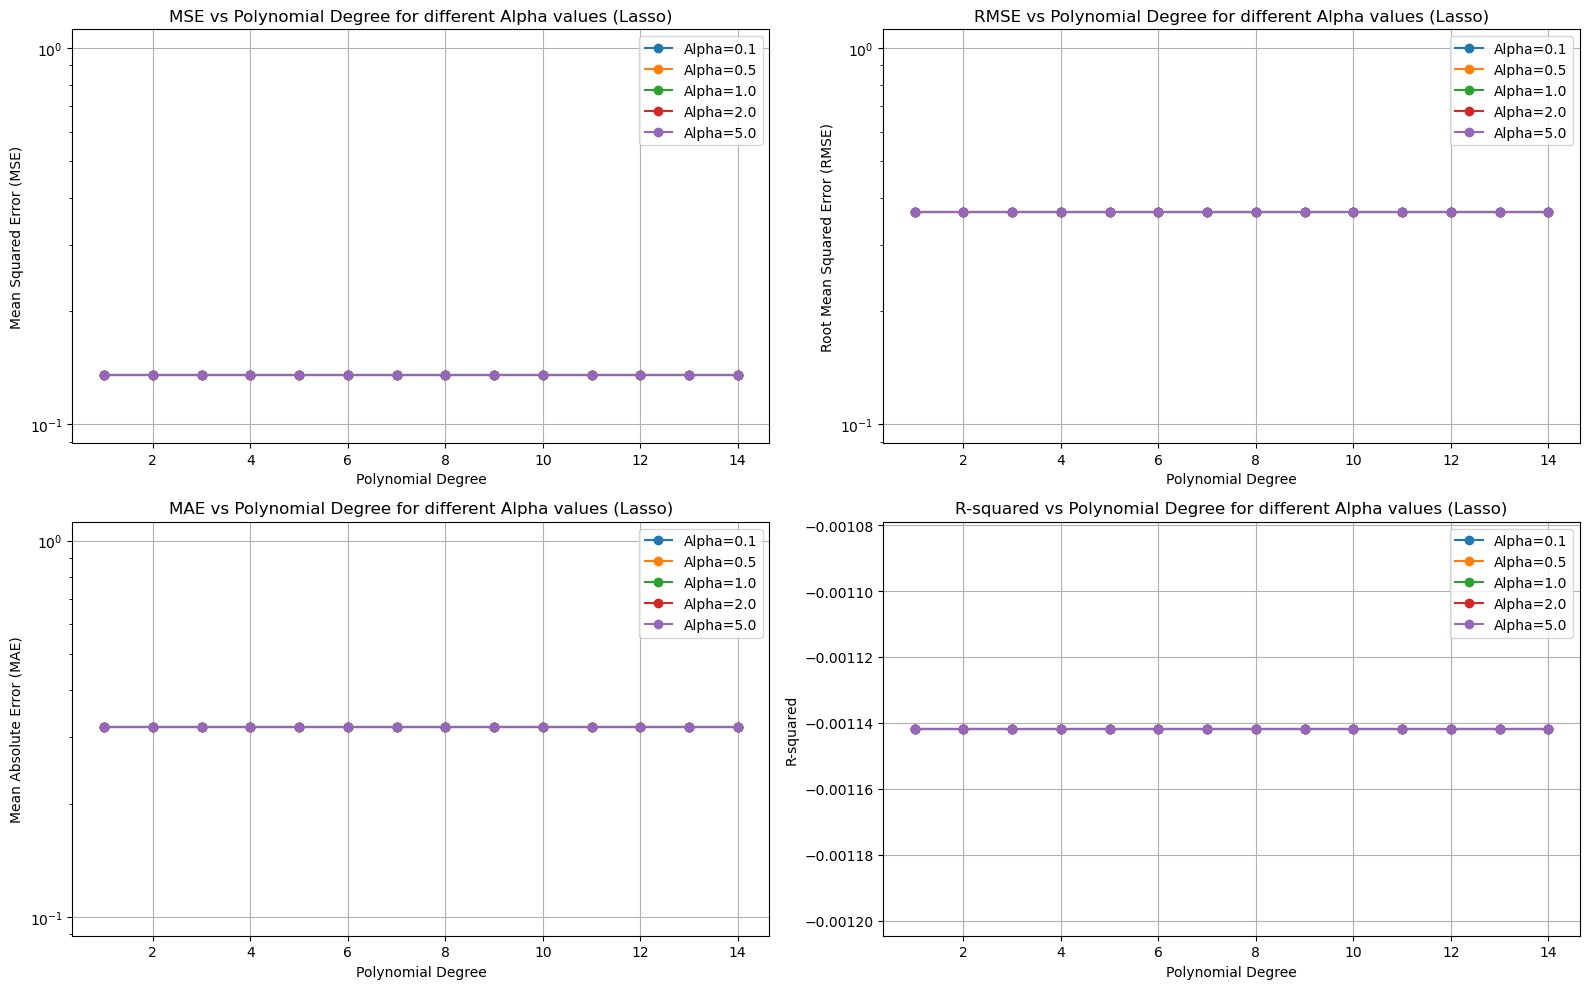

MSE für degree=6 und Alpha=0.1: 0.1350419801087637
MSE für degree=6 und Alpha=0.5: 0.1350419801087637
MSE für degree=6 und Alpha=1.0: 0.1350419801087637
MSE für degree=6 und Alpha=2.0: 0.1350419801087637
MSE für degree=6 und Alpha=5.0: 0.1350419801087637


In [14]:
# Testing L1 regularization

from sklearn.linear_model import Lasso

degrees = np.arange(1, 15)
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0]
mse_values = np.zeros((len(alpha_values), len(degrees)))
rmse_values = np.zeros((len(alpha_values), len(degrees)))
mae_values = np.zeros((len(alpha_values), len(degrees)))
r2_values = np.zeros((len(alpha_values), len(degrees)))

for i, alpha in enumerate(alpha_values):
    for j, degree in enumerate(degrees):
        poly_features = PolynomialFeatures(degree=degree)
        site_1_X_train_poly = poly_features.fit_transform(site_1_X_train)
        site_1_X_val_poly = poly_features.transform(site_1_X_val)

        model = Lasso(alpha=alpha)
        model.fit(site_1_X_train_poly, site_1_y_train)

        y_pred = model.predict(site_1_X_val_poly)

        mse = mean_squared_error(site_1_y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(site_1_y_val, y_pred)
        r2 = r2_score(site_1_y_val, y_pred)

        mse_values[i, j] = mse
        rmse_values[i, j] = rmse
        mae_values[i, j] = mae
        r2_values[i, j] = r2

# Plot the results
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale('log')
plt.title('MSE vs Polynomial Degree for different Alpha values (Lasso)')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, rmse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale('log')
plt.title('RMSE vs Polynomial Degree for different Alpha values (Lasso)')
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mae_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale('log')
plt.title('MAE vs Polynomial Degree for different Alpha values (Lasso)')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, r2_values[i], marker='o', label=f'Alpha={alpha}')
plt.title('R-squared vs Polynomial Degree for different Alpha values (Lasso)')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the MSE for degree=6 for each alpha value
for i, alpha in enumerate(alpha_values):
    print(f"MSE für degree=6 und Alpha={alpha}: {mse_values[i, 5]}")

[-0.10941744 -0.40513847  1.29034736  0.65117614]


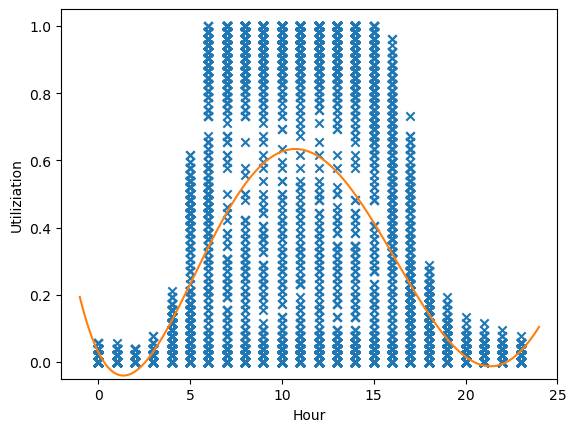

In [17]:
def plot_regression_poly(x, y, d):
    
    #Scaling data using min-max method
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1
    
    #Creating Polynomial features
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    
    #Solving normal equation and finding coefficients
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt = 2* (xt0 - min_x)/(max_x - min_x) -1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
        
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Hour")
    plt.ylabel("Utiliziation")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])
    #plt.savefig('all data_reg_'+str(d)+'.png', dpi = 300)

plot_regression_poly(x = xp, y=yp, d = 6)

In [22]:
# Hier gehe ich davon aus, dass Ihre Spalte mit den Stunden "hour" heißt
# und die Spalte mit der Nutzung "utilization" heißt.
# Bitte passen Sie die Spaltennamen entsprechend an.

# Filtern Sie die Daten, um Feiertage und Wochenenden zu entfernen
filtered_data2 = site_1[(site_1['holiday'] == False) & (site_1['weekday'] < 5)]

# Erstellen Sie eine Pivot-Tabelle für die Heatmap
heatmap_data = filtered_data.pivot_table(index='utilization', columns='hour', aggfunc='size', fill_value=0)

# Erstellen Sie die Heatmap mit umgekehrter Y-Achse
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data[::-1], cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Utilization'})

# Einstellungen für die Achsenbeschriftungen und den Plot-Titel
plt.xlabel('Hour')
plt.ylabel('Utilization')
plt.title('Utilization Heatmap for Site 1 (excluding holidays and weekends)')

# Zeigen Sie die Heatmap an
plt.show()

NameError: name 'filtered_data' is not defined

In [16]:
filtered_data

NameError: name 'filtered_data' is not defined

In [17]:
print(site_1.corr())

                   hour   weekday     month   holiday  utilization  \
hour           1.000000  0.000275 -0.000168 -0.000844    -0.040150   
weekday        0.000275  1.000000 -0.000691 -0.125544    -0.346962   
month         -0.000168 -0.000691  1.000000  0.000380    -0.028546   
holiday       -0.000844 -0.125544  0.000380  1.000000    -0.102660   
utilization   -0.040150 -0.346962 -0.028546 -0.102660     1.000000   
temperature    0.227133 -0.002021  0.233564 -0.071864     0.290655   
precipitation -0.014741 -0.007683 -0.021305 -0.000130     0.005524   

               temperature  precipitation  
hour              0.227133      -0.014741  
weekday          -0.002021      -0.007683  
month             0.233564      -0.021305  
holiday          -0.071864      -0.000130  
utilization       0.290655       0.005524  
temperature       1.000000      -0.097912  
precipitation    -0.097912       1.000000  


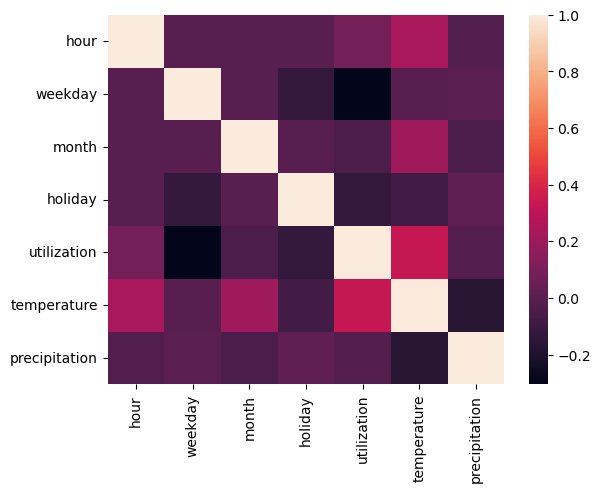

In [18]:
sns.heatmap(site_1.corr(method = "spearman"));

In [19]:
sns.heatmap(filtered_data.corr(method = "spearman"));

NameError: name 'filtered_data' is not defined

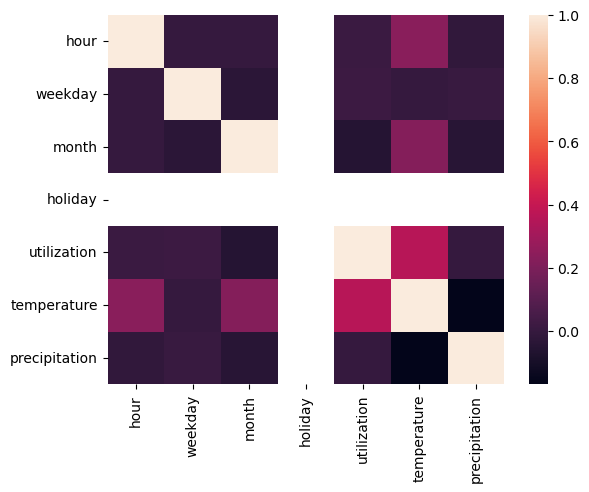

In [20]:
sns.heatmap(filtered_data2.corr(method = "spearman"));

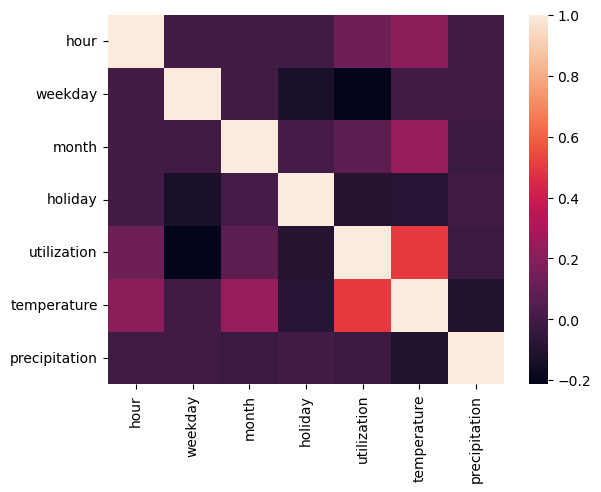

In [21]:
sns.heatmap(site_2.corr());